# First Assignment

A company produces a set of products at $I$ plants. It then ships these products to $J$ market zones.
For $i = 1,...,I$ and $j = 1,...,J$, the following data are given:

$v_{i} \equiv$ variable cost of producing one unit of product at plant $i$.

$c_{ij} \equiv$ cost of shipping one unit of product from plant $i$ to market $j$.

$d_{j} \equiv$ demand for products at market $j$.

$M_{i} \equiv$ maximum number or products produced at plant $i$.

$p_{j} \equiv$ selling price for products at market $j$.

$F \equiv $ maximum transportation capacity between plant $i$ and market $j$ (assume all transportation capacities are equal).

**a)** Formulate the problem (linear program) of maximizing the total profit that the
company is facing (total selling revenue - total production and transportation costs) by
identifying the optimal production and transportation schedule. Assume also that demand
is satisfy with "equality", i.e., "total product reaching market $j$" = $d_{j}$ ).

**SOLUTION**

First of all, the $I \cdot J$ variables of our problem are the following ones:

$X_{ij} \equiv$ units produced in market $i$ and sold in market $j$.  

Then the optimization problem is:

 $$ \max \sum_{i=1}^{I}  \sum_{j=1}^{J} p_{j} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} v_{i} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} c_{ij} X_{ij}$$
 

s.t.

$\displaystyle \sum_{i=1}^{I} X_{ij} = d_{j} \quad j=1,...,J \quad $  (We have to satisfy the demand of $J$ markets)

$\displaystyle \sum_{j=1}^{J} X_{ij} \le M_{i} \quad i=1,...,I \quad $  (We can not produce more than the capacity for each of the $I$ plants)

$X_{ij} \le F \quad j=1,...,J \quad i=1,...,I \quad $ (We can not transport more than $F$ from plant $i$ to market $j$)

$X_{ij} \ge 0 \quad j=1,...,J \quad i=1,...,I \quad $ (We can not produce negative units)

**b)** Implement the model in Pyomo as an "AbstractModel()" and solve it considering
5 plants and 6 markets and randomly generated parameters. For the random generation of
these parameters consider uniform distributions within the following ranges: $v_{i} \in [1.5 , 2.5] $,
$c_{ij} \in [1,2]$, $dj \in [275, 325]$, $M_{i} \in [400, 900]$, $p_{j} \in [4, 5]$ and  $F \in[250, 350]$.

Firstly, we need to create the model. The model will be created inside plants_to_markets funciton.

In [1]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def plants_to_markets(I,J,v,c,d,M,p,F):
    
    model = AbstractModel()
    
    model.I = RangeSet(1,I) #plants
    model.J = RangeSet(1,J) #markets
    
    #We create I·J non negative variables 
    model.x = Var(model.I,model.J, domain=NonNegativeReals) 
    
    #Objective function:
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    #the next line creates the objective function 
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    #Maximum flow (in the problem it is constant, but we are going to create I·J and then assign themm the same value)
    def F_constraint_rule(model, i,j): 
        return model.x[i,j] <= F[i-1,j-1]
    
    #the next line creates one constraint for each of the I·Jpossible paths between plants and markets
    model.F_constraint = Constraint(model.I,model.J, rule=F_constraint_rule)

    #Demand constraint
    def d_constraint_rule(model, j): 
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each of the J markets
    model.d_constraint = Constraint(model.J, rule=d_constraint_rule)

    #Production constraint
    def M_constraint_rule(model, i):
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    #the next line creates one constraint for each of the I plants
    model.M_constraint = Constraint(model.I, rule=M_constraint_rule)

    #We create the an instance of model
    instance = model.create_instance()
    
    #We use the function solve from Solverfactory inputing the model's instance
    results = opt.solve(instance)
    
    #Then we save the solution of the problem in the matrix x_sol

    x_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value
    
    return instance.OBJ(), x_sol

When the function has been created, we define the input parameters of our problem (I used np.random.seed(13), for example). I have considered the demmand, the maximum production and the maximum flow per line as integer numbers:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
 
np.random.seed(13)

I = 5 #plants
J = 6 #markets
v = np.random.uniform(1.5, 2.5, I) #I varibles of production cost
c = np.random.uniform(1, 2, (I,J)) #I·J variables of transport costs
d = np.random.uniform(275, 325, J).astype(int) #J varibles of demmand 
M = np.random.uniform(400, 900, I).astype(int) #I varibles of maximum production 
p = np.random.uniform(4, 5, J) #J varibles of price
F = np.ones((I,J))*np.random.uniform(250, 350, 1)[0].astype(int) #constant varible of maximum flow

Now we apply the function that we have defined before and we get the values of variables as well as the objective function's value.

In [18]:
obj,x_sol=plants_to_markets(I,J,v,c,d,M,p,F)

In [19]:
obj

2206.234027347951

In [21]:
x_sol

array([[   0.,    0.,    0.,   47.,    0.,  246.],
       [ 263.,  263.,    0.,  263.,   28.,   42.],
       [  59.,   12.,    0.,    0.,  263.,    0.],
       [   0.,    0.,  263.,    0.,    0.,    0.],
       [   0.,    0.,   24.,    0.,    0.,    0.]])

We can see that if we produce what is indicated in the matrix x_sol we would obtain the optimal solution. We would win 2206.23 monetary units.

**c)** Considering the results: which plant's maximum capacity would be more beneficial
to increase? and in which market would be more beneficial to increase the demand? Justify
your answers.

Let's see first for the plant's maximum capacity. The capacities are:

In [22]:
M

array([747, 859, 522, 629, 526])

The value of the objective function is:

In [23]:
obj

2206.234027347951

Now we are going to write a code in which we plot the evolution of the objective function if we increase the capacity of the different plants up to 100 more.

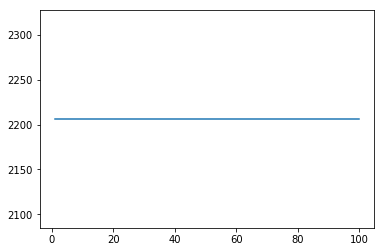

In [25]:
solutions_capacity_plant1=[]
M1=copy.deepcopy(M)
j=0
for i in range(M[0],M[0]+100):
    M1[0]=M1[0]+1
    x_sol=plants_to_markets(I,J,v,c,d,M1,p,F)
    solutions_capacity_plant1.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_capacity_plant1)



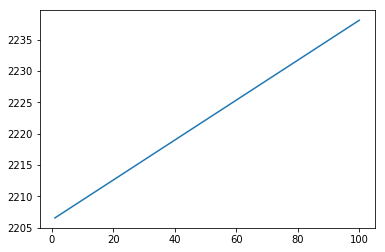

In [26]:
solutions_capacity_plant2=[]
M2=copy.deepcopy(M)
j=0
for i in range(M[1],M[1]+100):
    M2[1]=M2[1]+1
    x_sol=plants_to_markets(I,J,v,c,d,M2,p,F)
    solutions_capacity_plant2.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_capacity_plant2)

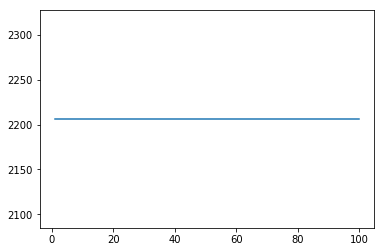

In [28]:
solutions_capacity_plant3=[]
M3=copy.deepcopy(M)
j=0
for i in range(M[2],M[2]+100):
    M3[2]=M3[2]+1
    x_sol=plants_to_markets(I,J,v,c,d,M3,p,F)
    solutions_capacity_plant3.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_capacity_plant3)

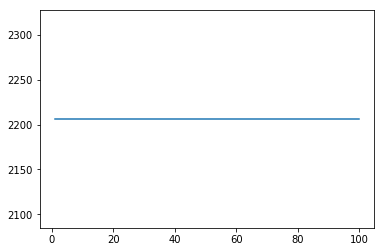

In [29]:
solutions_capacity_plant4=[]
M4=copy.deepcopy(M)
j=0
for i in range(M[3],M[3]+100):
    M4[3]=M4[3]+1
    x_sol=plants_to_markets(I,J,v,c,d,M4,p,F)
    solutions_capacity_plant4.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_capacity_plant4)

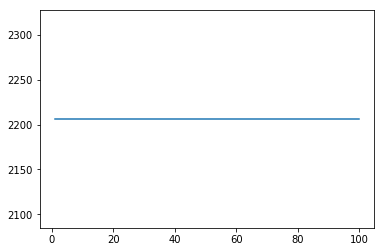

In [30]:
solutions_capacity_plant5=[]
M5=copy.deepcopy(M)
j=0
for i in range(M[4],M[4]+100):
    M5[4]=M5[4]+1
    x_sol=plants_to_markets(I,J,v,c,d,M5,p,F)
    solutions_capacity_plant5.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_capacity_plant5)

From the plots we can see that the best plant to increase its capacity is plant 2, in fact, it is the only one that also increases the benefit.

Now we do exactly the same for the different market demmands.

In [31]:
d

array([322, 275, 287, 310, 291, 288])

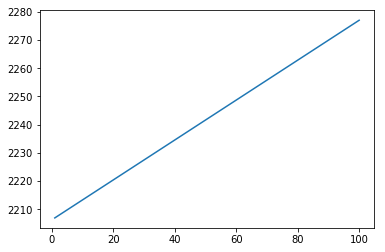

In [32]:
solutions_demmand_market1=[]
d1=copy.deepcopy(d)
j=0
for i in range(d[0],d[0]+100):
    d1[0]=d1[0]+1
    x_sol=plants_to_markets(I,J,v,c,d1,M,p,F)
    solutions_demmand_market1.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_demmand_market1)

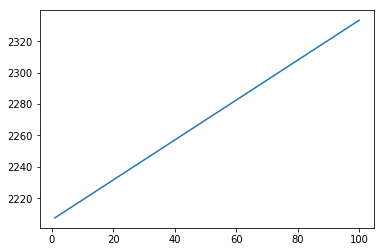

In [33]:
solutions_demmand_market2=[]
d2=copy.deepcopy(d)
j=0
for i in range(d[1],d[1]+100):
    d2[1]=d2[1]+1
    x_sol=plants_to_markets(I,J,v,c,d2,M,p,F)
    solutions_demmand_market2.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_demmand_market2)

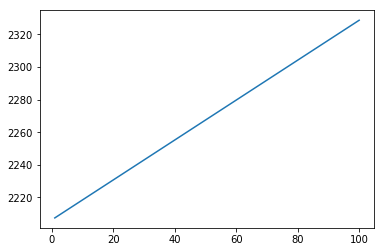

In [38]:
solutions_demmand_market3=[]
d3=copy.deepcopy(d)
j=0
for i in range(d[2],d[2]+100):
    d3[2]=d3[2]+1
    x_sol=plants_to_markets(I,J,v,c,d3,M,p,F)
    solutions_demmand_market3.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_demmand_market3)

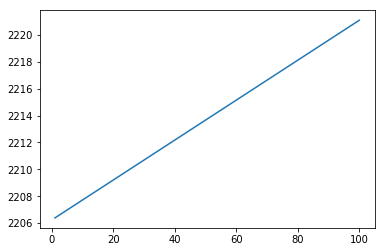

In [39]:
solutions_demmand_market4=[]
d4=copy.deepcopy(d)
j=0
for i in range(d[3],d[3]+100):
    d4[3]=d4[3]+1
    x_sol=plants_to_markets(I,J,v,c,d4,M,p,F)
    solutions_demmand_market4.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_demmand_market4)

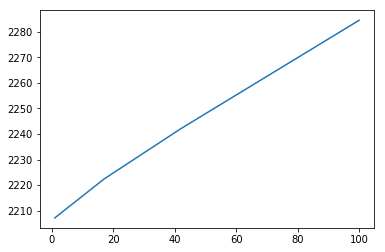

In [40]:
solutions_demmand_market5=[]
d5=copy.deepcopy(d)
j=0
for i in range(d[4],d[4]+100):
    d5[4]=d5[4]+1
    x_sol=plants_to_markets(I,J,v,c,d5,M,p,F)
    solutions_demmand_market5.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_demmand_market5)

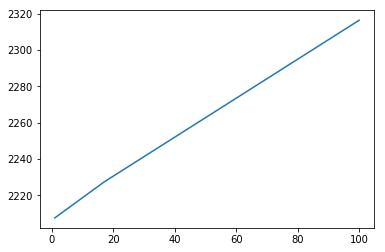

In [41]:
solutions_demmand_market6=[]
d6=copy.deepcopy(d)
j=0
for i in range(d[5],d[5]+100):
    d6[5]=d6[5]+1
    x_sol=plants_to_markets(I,J,v,c,d6,M,p,F)
    solutions_demmand_market6.append(x_sol[0])
    j=j+1
    
plt.plot(range(1,j+1),solutions_demmand_market6)

In [43]:
print(max(solutions_demmand_market2))
print(solutions_demmand_market2[0])
print(max(solutions_demmand_market3))
print(solutions_demmand_market3[0])

2333.31877994
2207.50487487
2328.64004731
2207.45808755


From the plots and the last 4 lines of code we can see that the best market to increase its demmand is market 2.

**d)** Modify the formulation in a) to impose that:

$\quad$**1.** Each plant is allowed to send its products to a maximum of 5 diferent markets.

$\quad$**2.** Plants, if operative, cannot produce less than 10% of their maximum capacity,
i.e., a plant can produce either 0 products (if not operative) or a quantity greater than
10% of its maximum capacity (if operative).

Solve the resulting model in Pyomo and interpret the new results. 

**SOLUTION**

**Now we have $2 \cdot I \cdot J + I$ variables**:

$X_{ij} \equiv$ units produced in market $i$ and sold in market $j$.  

**$Y_{ij} \equiv$ 1 if the plant $i$ sends units to market $j$, 0 if not.** 

**$A_{i} \equiv$ 1 if the plant $i$ is active, 0 if not.** (This last variale is needed for the second and the third constraint inequation due to the fact that, if the plant $i$ does not produce, then 0 would be greater or equal than a positive number)

Then the optimization problem is:

 $$ \max \sum_{i=1}^{I}  \sum_{j=1}^{J} p_{j} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} v_{i} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} c_{ij} X_{ij}$$

s.t.

$\displaystyle \sum_{i=1}^{I} X_{ij} = d_{j} \quad j=1,...,J \quad $  (We have to satisfy the demand of $J$ markets)

$\displaystyle \sum_{j=1}^{J} X_{ij} \le M_{i} A_{i} \quad i=1,...,I \quad $  (**If the plant produces, we can not produce more than the capacity for each of the $I$ plants**)

$\displaystyle \sum_{j=1}^{J} X_{ij} \ge 0.1 M_{i} A_{i}\quad i=1,...,I \quad $  (**If the plant produces , we can not produce less than the 10% of its capacity**)

$X_{ij} \le Y_{ij} F  \quad j=1,...,J \quad i=1,...,I \quad $ (**If the plant $i$ produces for market $j$, we can not transport more than $F$ from plant $i$ to market $j$**)

$X_{ij} \ge 0 \quad j=1,...,J \quad i=1,...,I \quad $ (We can not produce negative units)

$\displaystyle \sum_{j=1}^{J} Y_{ij} \le 5 \quad i=1,...,I \quad $  (**Each plant can not send to more than 5 markets**)

Now we need to create the model. The model will be created inside plants_to_markets_modif funciton.

In [24]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def plants_to_markets_modif(I,J,v,c,d,M,p,F):
    
    model = AbstractModel()
    
    model.I = RangeSet(1,I) #plants
    model.J = RangeSet(1,J) #markets
    
    #We create I·J non negative variables 
    model.x = Var(model.I,model.J, domain=NonNegativeReals) 
    
    #We need to add I·J binary variables
    model.y = Var(model.I,model.J, domain=Binary)
    
    #We also need to add I binary variables
    model.a = Var(model.I, domain=Binary)
    
    #Objective function:
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    #the next line creates the objective function 
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    #Maximum flow (in the problem it is constant, but we are going to create I·J and then assign themm the same value)
    def F_constraint_rule(model, i,j): 
        return model.x[i,j] <= F[i-1,j-1]*model.y[i,j]
    
    #the next line creates one constraint for each of the I·Jpossible paths between plants and markets
    model.F_constraint = Constraint(model.I,model.J, rule=F_constraint_rule)

    #Demand constraint
    def d_constraint_rule(model, j): 
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each of the J markets
    model.d_constraint = Constraint(model.J, rule=d_constraint_rule)

    #Upper bound production constraint
    def M_constraint_rule(model, i): 
        return sum(model.x[i,j] for j in model.J)<= M[i-1]*model.a[i]
    
    #the next line creates one constraint for each of the I plants
    model.M_constraint = Constraint(model.I, rule=M_constraint_rule)
    
    #Lower bound production constraint
    def Ml_constraint_rule(model, i): 
        return sum(model.x[i,j] for j in model.J)>= 0.1*M[i-1]*model.a[i]
    
    #the next line creates one constraint for each of the I plants
    model.Ml_constraint = Constraint(model.I, rule=Ml_constraint_rule)
    
    #No more than 5 markets constraint
    def Y_constraint_rule(model,i): 
        return   sum(model.y[i,j] for j in model.J) <= 5
    
    #the next line creates one constraint for each of the I plants
    model.Y_constraint = Constraint(model.I,rule=Y_constraint_rule)
    

    #We create the an instance of model
    instance = model.create_instance()
    
    #We use the function solve from Solverfactory inputing the model's instance
    results = opt.solve(instance)
    
    #Then we save the solution of the problem in the matrix x_sol

    x_sol = np.zeros((I,J))
    
     
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value
    
    y_sol = np.zeros((I,J))
    
    for i in range(0, I):
            for j in range(0,J):
                y_sol[i,j]=instance.y[i+1,j+1].value
    a_sol = np.zeros(I)
    
    for i in range(0, I):
        a_sol[i]=instance.a[i+1].value           
    
    return instance.OBJ(), x_sol, y_sol, a_sol

With the same input data we obtain the following results:

In [30]:
obj,x_sol,y_sol,a_sol=plants_to_markets_modif(I,J,v,c,d,M,p,F)

In [31]:
obj

2205.733961353191

In [32]:
x_sol

array([[   0. ,    0. ,    0. ,   47. ,    0. ,  246. ],
       [ 263. ,  263. ,    0. ,  263. ,   28. ,   42. ],
       [  59. ,   12. ,    0. ,    0. ,  263. ,    0. ],
       [   0. ,    0. ,  234.4,    0. ,    0. ,    0. ],
       [   0. ,    0. ,   52.6,    0. ,    0. ,    0. ]])

In [33]:
y_sol

array([[ 0.,  0.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.]])

In [29]:
a_sol

array([ 1.,  1.,  1.,  1.,  1.])

If we take a look at the solution and we compare it with the solution of the first problem what mainly happens is that, in the first solution, the units produced in the third plant were 24, which is less than the 10% of the plant's capacity (522). That is why we forced to produce at least the 10% and we obtained the value 52.6 in this plant. Obviusly, the objective function's value has decreased a little.